## Import packages

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
!git clone https://github.com/YoussefAboelwafa/Face-Recognition.git

Cloning into 'Face-Recognition'...
remote: Enumerating objects: 1152, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1152 (delta 4), reused 0 (delta 0), pack-reused 1143 (from 1)
Receiving objects: 100% (1152/1152), 26.12 MiB | 29.36 MiB/s, done.
Resolving deltas: 100% (134/134), done.


### load images from file

In [ ]:
import os
import numpy as np
from PIL import Image

def load_images(path):
    images = []
    labels = []
    if "non" in path:  # caso nonfaces
        for i, dir in enumerate(os.listdir(path)):
            dir_path = os.path.join(path, dir)
            if os.path.isdir(dir_path):  # asegúrate de no abrir carpetas
                for file in os.listdir(dir_path):
                    file_path = os.path.join(dir_path, file)
                    if os.path.isfile(file_path):
                        img = Image.open(file_path).convert('L')
                        img = img.resize((92,112))
                        images.append(np.array(img).flatten())
                        labels.append(i+1)
    else:  # caso faces
        for i, dir in enumerate(os.listdir(path)):
            dir_path = os.path.join(path, dir)
            if os.path.isdir(dir_path):
                for file in os.listdir(dir_path):
                    file_path = os.path.join(dir_path, file)
                    if os.path.isfile(file_path):
                        img = Image.open(file_path)
                        images.append(np.array(img).flatten())
                        labels.append(i+1)
    return np.array(images), np.array(labels).reshape(-1,1)

faces, labels = load_images('/content/Face-Recognition/datasets/faces')
non_faces, non_labels = load_images('/content/Face-Recognition/datasets/nonfaces')

faces_labels = np.ones((len(faces),1))
non_faces_labels = np.zeros((len(non_faces),1))

print(faces.shape, faces_labels.shape)
print(non_faces.shape, non_faces_labels.shape)

(400, 10304) (400, 1)
(550, 10304) (550, 1)


## Suffle the images and labels

In [ ]:
def shuffle_data(data, labels):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    return data[idx], labels[idx]

faces, labels = shuffle_data(faces, labels)
non_faces, non_labels = shuffle_data(non_faces, non_labels)

## Plot the data

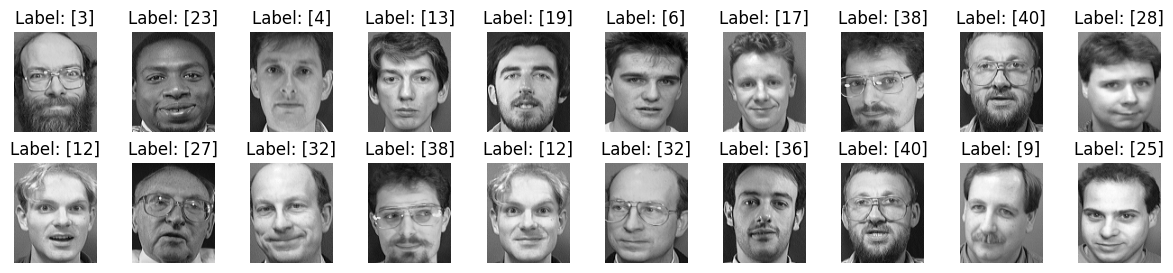

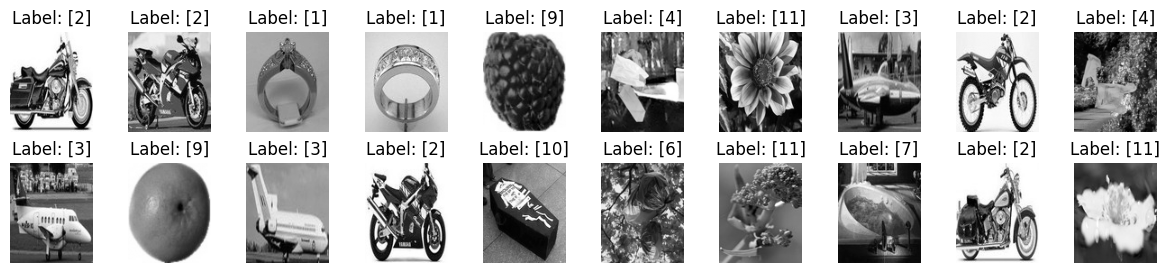

In [ ]:
def plot_data(faces, labels, n=100):
    num_rows = n // 10
    fig, axs = plt.subplots(num_rows, 10, figsize=(15, 1.5 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(faces[i].reshape((112, 92)), cmap="gray")
        axs[i].set_title(f"Label: {labels[i]}")
        axs[i].axis("off")
    plt.show()

plot_data(faces, labels,20)
plot_data(non_faces, non_labels,20)

## split the dataset into training and testing

In [ ]:

# function to split the data into training and testing which alpha is the percentage of the training data
def split_data(faces, faces_labels, non_faces,non_faces_labels,non_faces_count,alpha,non_face_precentage_in_train=1):
    if alpha == 0.5:
        faces_train = faces[::2]
        faces_train_labels = faces_labels[::2]
        faces_test = faces[1::2]
        faces_test_labels = faces_labels[1::2]

        non_faces_train = non_faces[:int(non_faces_count*non_face_precentage_in_train):2]
        non_faces_train_labels = non_faces_labels[:int(non_faces_count*non_face_precentage_in_train):2]

        non_faces_test = non_faces[1:non_faces_count:2]
        non_faces_test_labels = non_faces_labels[1:non_faces_count:2]
    else:
        n = len(faces)
        n_train = int(n*alpha)
        idx = np.random.permutation(n)
        train_idx = idx[:n_train]
        test_idx = idx[n_train:]
        faces_train = faces[train_idx]
        faces_train_labels = faces_labels[train_idx]
        faces_test = faces[test_idx]
        faces_test_labels = faces_labels[test_idx]
        n = non_faces_count
        n_train = int(n*alpha)
        idx = np.random.permutation(n)
        train_idx = idx[:n_train]
        test_idx = idx[n_train:]
        non_faces_train = non_faces[train_idx]
        non_faces_train_labels = non_faces_labels[train_idx]
        non_faces_test = non_faces[test_idx]
        non_faces_test_labels = non_faces_labels[test_idx]

    return np.append(faces_train, non_faces_train, axis=0), np.append(faces_train_labels, non_faces_train_labels, axis=0), np.append(faces_test, non_faces_test, axis=0), np.append(faces_test_labels, non_faces_test_labels, axis=0)


In [ ]:

train_data, train_labels, test_data, test_labels = split_data(faces, faces_labels, non_faces, non_faces_labels,400 , 0.5, 1)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(400, 10304) (400, 1) (400, 10304) (400, 1)


# display samples of training data and test data

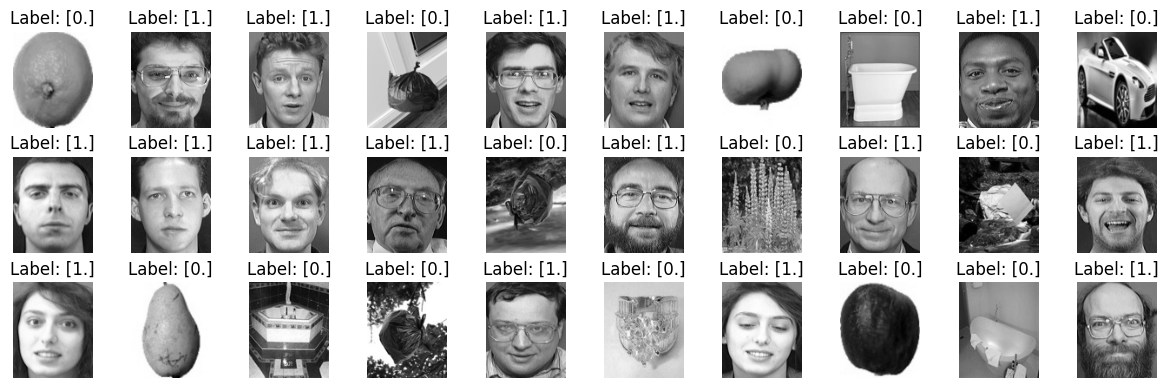

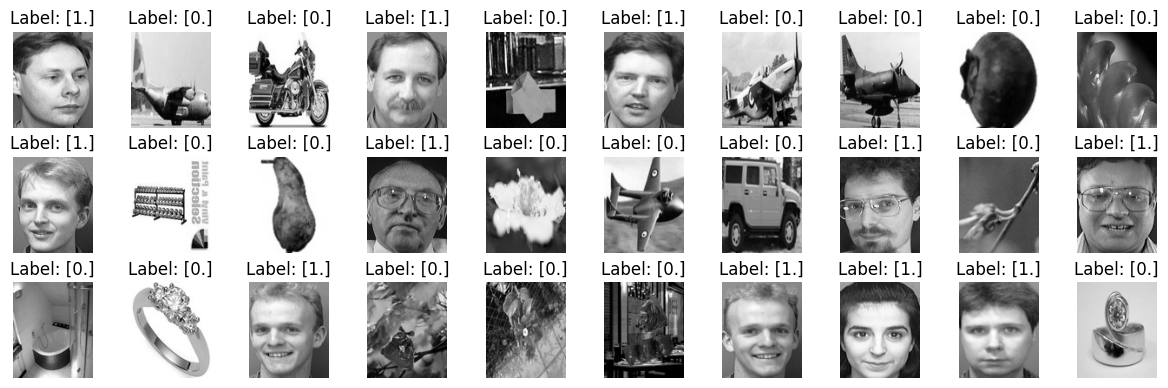

In [ ]:
train_data, train_labels = shuffle_data( train_data,train_labels)
test_data, test_labels = shuffle_data( test_data,  test_labels)

plot_data(train_data, train_labels,30)
plot_data(test_data, test_labels,30)

# PCA imlementation

In [ ]:
def PCA(train_data,alpha=0.95):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean

    cov_matrix = np.dot(centered_data,centered_data.T)
    # cov_matrix = np.cov(centered_data,rowvar=False,bias=True)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]

    eig_vectors = np.dot(centered_data.T,eig_vectors)

    for i in range(eig_vectors.shape[1]):
        eig_vectors[:,i] = eig_vectors[:,i]/np.linalg.norm(eig_vectors[:,i])

    total = np.sum(eig_values)
    k = 0
    var = 0
    while var/total < alpha:
        var += eig_values[k]
        k += 1
    print(f"Using {k} components to retain {alpha*100}% of the variance")
    return eig_vectors[:,:k], mean

space,mean= PCA(train_data,0.85)


Using 40 components to retain 85.0% of the variance


# Plot the eign images

# PCA imlementation

In [ ]:
# Bloque 1: PCA
def PCA(train_data, alpha=0.95):
    X = np.asarray(train_data, dtype=np.float64)
    mean = np.mean(X, axis=0)
    centered_data = X - mean

    cov_matrix = np.dot(centered_data, centered_data.T)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]

    eig_vectors = np.dot(centered_data.T, eig_vectors)

    for i in range(eig_vectors.shape[1]):
        norm = np.linalg.norm(eig_vectors[:, i])
        if norm > 0:
            eig_vectors[:, i] = eig_vectors[:, i] / norm

    total = np.sum(eig_values)
    k = 0
    var = 0.0
    while k < len(eig_values) and var / total < alpha:
        var += eig_values[k]
        k += 1
    print(f"[PCA] Using {k} components to retain {alpha*100:.1f}% of the variance")
    return eig_vectors[:, :k], mean

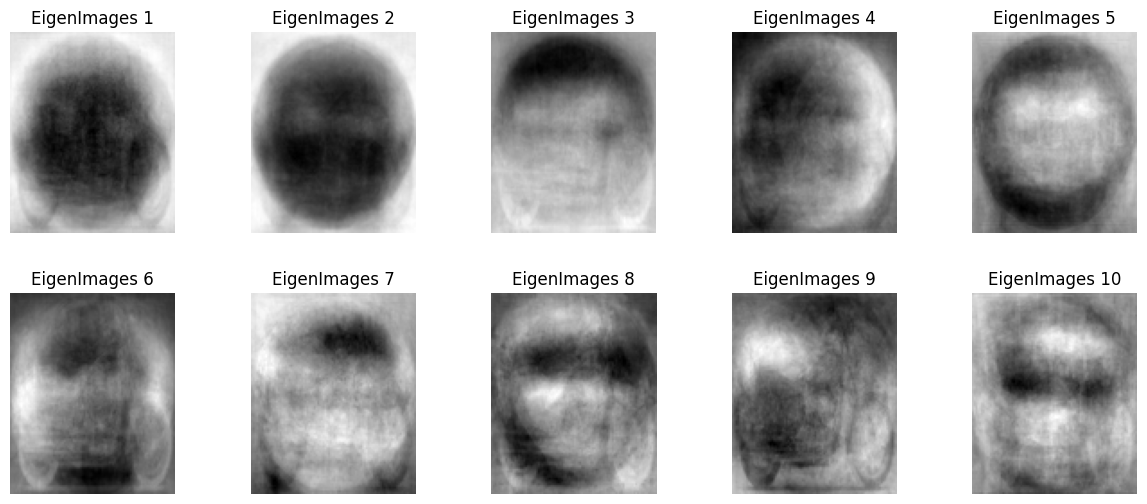

In [ ]:
def plot_eigenfaces(eigenvectors, n=10):
    num_rows = n // 5
    _, axs = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(eigenvectors[:, i].reshape((112, 92)), cmap="gray")
        axs[i].set_title(f"EigenImages {i+1}")
        axs[i].axis("off")
    plt.show()
plot_eigenfaces(space, 10)

# LDA

In [ ]:
# Bloque 2: LDA binaria
def LDA(train_data, train_labels, k=1):
    y = safe_ravel_labels(train_labels)
    X = np.asarray(train_data, dtype=np.float64)
    assert set(np.unique(y)).issubset({0,1}), "Esta LDA es binaria (clases 0/1)."

    mean1 = np.mean(X[y == 1], axis=0)
    mean0 = np.mean(X[y == 0], axis=0)

    Sw = np.dot((X[y == 1] - mean1).T, (X[y == 1] - mean1)) + \
         np.dot((X[y == 0] - mean0).T, (X[y == 0] - mean0))

    Sb = np.dot((mean1 - mean0).reshape(-1,1), (mean1 - mean0).reshape(-1,1).T)

    eig_values, eig_vectors = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))
    eig_values = np.real(eig_values)
    eig_vectors = np.real(eig_vectors)

    idx = np.argsort(eig_values)[::-1]
    eig_vectors = eig_vectors[:, idx]
    return eig_vectors[:, :k]

In [ ]:
# Bloque 3: ICA (FastICA minimal)
def ICA(train_data, n_components, max_iter=200, tol=1e-5, random_state=0):
    """
    Retorna:
      P (d x k): matriz de proyección
      mean (d,)
    """
    rng = np.random.default_rng(random_state)
    X = np.asarray(train_data, dtype=np.float64)
    mean = X.mean(axis=0)
    Xc = X - mean

    # SVD para blanqueo
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    eps = 1e-12
    S_inv = 1.0 / np.maximum(S, eps)
    K = (Vt.T * S_inv)         # d x r
    X_white = U                # n x r

    k = int(n_components)
    W = rng.standard_normal((k, X_white.shape[1]))

    def sym_decorrelate(W):
        A = W @ W.T
        ev, E = np.linalg.eigh(A)
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(ev, eps)))
        return (E @ D_inv_sqrt @ E.T) * 1.0 @ W

    W = sym_decorrelate(W)

    for _ in range(max_iter):
        WX = W @ X_white.T                 # k x n
        gWX = np.tanh(WX)
        gprime = 1.0 - gWX**2              # k x n

        W_new = (gWX @ X_white) / X_white.shape[0] - (gprime.mean(axis=1)[:, None]) * W
        W_new = sym_decorrelate(W_new)

        delta = np.max(np.abs(np.abs(np.diag(W_new @ W.T)) - 1.0))
        W = W_new
        if delta < tol:
            break

    P = K @ W.T   # d x k
    return P, mean


In [ ]:
# Bloque 4: Clasificador y métricas
def fit_nearest_centroid(X_emb, y):
    """
    X_emb: (n_samples, n_features)
    y: (n_samples,) o (n_samples,1)
    """
    y = safe_ravel_labels(y)
    assert X_emb.shape[0] == y.shape[0], f"X_emb tiene {X_emb.shape[0]} filas y y tiene {y.shape[0]}."
    classes = np.unique(y)
    centroids = {}
    for c in classes:
        Xi = X_emb[y == c]
        if Xi.size == 0:
            raise ValueError(f"La clase {c} no tiene muestras en train.")
        centroids[c] = _l2_normalize(Xi.mean(axis=0, keepdims=True))[0]
    return centroids, classes

def predict_scores(X_emb, centroids, classes):
    Xn = _l2_normalize(X_emb)
    C = np.stack([centroids[c] for c in classes], axis=0)  # (n_classes, d)
    assert Xn.shape[1] == C.shape[1], f"Dimensión incompatible: {Xn.shape[1]} vs {C.shape[1]}"
    return Xn @ C.T

def topk_accuracy(scores, y_true, classes, k=1):
    y_true = safe_ravel_labels(y_true)
    n_classes = scores.shape[1]
    k_eff = int(min(k, n_classes))
    idx = np.argpartition(-scores, kth=k_eff-1, axis=1)[:, :k_eff]
    topk_cls = np.take(classes, idx)
    hits = np.any(topk_cls == y_true[:, None], axis=1)
    return float(hits.mean())

def confusion_matrix(y_true, y_pred, labels=None):
    y_true = safe_ravel_labels(y_true)
    y_pred = safe_ravel_labels(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    L = labels.tolist()
    idx = {c:i for i,c in enumerate(L)}
    cm = np.zeros((len(L), len(L)), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm, L

def precision_recall_macro(y_true, y_pred, labels=None, eps=1e-12):
    cm, L = confusion_matrix(y_true, y_pred, labels)
    precisions, recalls = [], []
    for i,_ in enumerate(L):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        prec = tp / np.maximum(tp + fp, eps)
        rec  = tp / np.maximum(tp + fn, eps)
        precisions.append(prec)
        recalls.append(rec)
    return float(np.mean(precisions)), float(np.mean(recalls)), cm, L

def accuracy_from_threshold(pairs_emb1, pairs_emb2, y_same, threshold=0.5, metric='cosine'):
    """
    Verificación: y_same = 1 (misma identidad), 0 (distinta).
    """
    y_same = safe_ravel_labels(y_same).astype(int)
    if metric == 'cosine':
        a = _l2_normalize(pairs_emb1)
        b = _l2_normalize(pairs_emb2)
        sims = np.sum(a * b, axis=1)  # [-1, 1]
        y_pred = (sims >= threshold).astype(int)
    elif metric == 'euclidean':
        d = np.linalg.norm(pairs_emb1 - pairs_emb2, axis=1)
        y_pred = (d <= threshold).astype(int)
    else:
        raise ValueError("metric debe ser 'cosine' o 'euclidean'")
    return float((y_pred == y_same).mean())

def best_threshold(emb1, emb2, y_same, metric='cosine', grid=None):
    if grid is None:
        grid = np.linspace(-1, 1, 201) if metric == 'cosine' else np.linspace(0, 5, 201)
    best_acc, best_t = -1.0, None
    for t in grid:
        acc = accuracy_from_threshold(emb1, emb2, y_same, t, metric)
        if acc > best_acc:
            best_acc, best_t = acc, t
    return best_t, best_acc


In [ ]:
# Bloque 5: prepara tus datos aquí
# EJEMPLO (REEMPLAZA por tus arrays reales):
# train_data = ...
# test_data  = ...
# train_labels = ...
# test_labels  = ...

# Validaciones de forma
train_labels = safe_ravel_labels(train_labels)
test_labels  = safe_ravel_labels(test_labels)

assert train_data.shape[0] == train_labels.shape[0], "n_train y labels no coinciden."
assert test_data.shape[0]  == test_labels.shape[0],  "n_test y labels no coinciden."

print("train_data:", train_data.shape, "| test_data:", test_data.shape)
print("train_labels:", train_labels.shape, "| test_labels:", test_labels.shape)
n_classes = len(np.unique(train_labels))
print("Clases:", n_classes, np.unique(train_labels))

train_data: (400, 10304) | test_data: (400, 10304)
train_labels: (400,) | test_labels: (400,)
Clases: 2 [0. 1.]


In [ ]:
# Bloque 6: Evaluación PCA
space_pca, mean_pca = PCA(train_data, alpha=0.85)  # puedes cambiar el alpha
Xtr_pca = project(train_data, mean_pca, space_pca)
Xte_pca = project(test_data,  mean_pca, space_pca)

cent_pca, classes_pca = fit_nearest_centroid(Xtr_pca, train_labels)
scores_pca = predict_scores(Xte_pca, cent_pca, classes_pca)
y_pred_pca = classes_pca[np.argmax(scores_pca, axis=1)]

top1_pca = topk_accuracy(scores_pca, test_labels, classes_pca, k=1)
top5_pca = topk_accuracy(scores_pca, test_labels, classes_pca, k=5)
prec_pca, rec_pca, cm_pca, lab_pca = precision_recall_macro(test_labels, y_pred_pca)

print(f"[PCA] Top-1: {top1_pca:.4f} | Top-5: {top5_pca:.4f} | Precision(macro): {prec_pca:.4f} | Recall(macro): {rec_pca:.4f}")
print("Matriz de confusión (orden etiquetas):", lab_pca)
print(cm_pca)

[PCA] Using 40 components to retain 85.0% of the variance
[PCA] Top-1: 0.8150 | Top-5: 1.0000 | Precision(macro): 0.8535 | Recall(macro): 0.8150
Matriz de confusión (orden etiquetas): [0.0, 1.0]
[[130  70]
 [  4 196]]


In [ ]:
# Bloque 7: Evaluación LDA (binaria)
# k típico: 1 (una dirección discriminante). Cambia si quieres más.
W_lda = LDA(train_data, train_labels, k=1)

# Para consistencia, usa mean=0 en project (LDA ya está en el espacio de características):
zero_mean = np.zeros(train_data.shape[1], dtype=np.float64)
Xtr_lda = project(train_data, zero_mean, W_lda)
Xte_lda = project(test_data,  zero_mean, W_lda)

cent_lda, classes_lda = fit_nearest_centroid(Xtr_lda, train_labels)
scores_lda = predict_scores(Xte_lda, cent_lda, classes_lda)
y_pred_lda = classes_lda[np.argmax(scores_lda, axis=1)]

top1_lda = topk_accuracy(scores_lda, test_labels, classes_lda, k=1)
top5_lda = topk_accuracy(scores_lda, test_labels, classes_lda, k=5)
prec_lda, rec_lda, cm_lda, lab_lda = precision_recall_macro(test_labels, y_pred_lda)

print(f"[LDA] Top-1: {top1_lda:.4f} | Top-5: {top5_lda:.4f} | Precision(macro): {prec_lda:.4f} | Recall(macro): {rec_lda:.4f}")
print("Matriz de confusión (orden etiquetas):", lab_lda)
print(cm_lda)

[LDA] Top-1: 0.5000 | Top-5: 1.0000 | Precision(macro): 0.2500 | Recall(macro): 0.5000
Matriz de confusión (orden etiquetas): [0.0, 1.0]
[[200   0]
 [200   0]]


In [ ]:
# Bloque 8: Evaluación ICA
n_comp_ica = space_pca.shape[1]  # igual a #componentes usados por PCA
P_ica, mean_ica = ICA(train_data, n_components=n_comp_ica, max_iter=400, tol=1e-5, random_state=0)

Xtr_ica = project(train_data, mean_ica, P_ica)
Xte_ica = project(test_data,  mean_ica, P_ica)

cent_ica, classes_ica = fit_nearest_centroid(Xtr_ica, train_labels)
scores_ica = predict_scores(Xte_ica, cent_ica, classes_ica)
y_pred_ica = classes_ica[np.argmax(scores_ica, axis=1)]

top1_ica = topk_accuracy(scores_ica, test_labels, classes_ica, k=1)
top5_ica = topk_accuracy(scores_ica, test_labels, classes_ica, k=5)
prec_ica, rec_ica, cm_ica, lab_ica = precision_recall_macro(test_labels, y_pred_ica)

print(f"[ICA] Top-1: {top1_ica:.4f} | Top-5: {top5_ica:.4f} | Precision(macro): {prec_ica:.4f} | Recall(macro): {rec_ica:.4f}")
print("Matriz de confusión (orden etiquetas):", lab_ica)
print(cm_ica)

[ICA] Top-1: 0.4375 | Top-5: 1.0000 | Precision(macro): 0.4374 | Recall(macro): 0.4375
Matriz de confusión (orden etiquetas): [0.0, 1.0]
[[ 84 116]
 [109  91]]


In [ ]:
# Bloque 10: Resumen de resultados
def resumen(nombre, top1, top5, prec, rec):
    print(f"{nombre:<6} | Top-1: {top1:.4f} | Top-5: {top5:.4f} | Precision(macro): {prec:.4f} | Recall(macro): {rec:.4f}")

resumen("PCA", top1_pca, top5_pca, prec_pca, rec_pca)
resumen("LDA", top1_lda, top5_lda, prec_lda, rec_lda)
resumen("ICA", top1_ica, top5_ica, prec_ica, rec_ica)


PCA    | Top-1: 0.8150 | Top-5: 1.0000 | Precision(macro): 0.8535 | Recall(macro): 0.8150
LDA    | Top-1: 0.5000 | Top-5: 1.0000 | Precision(macro): 0.2500 | Recall(macro): 0.5000
ICA    | Top-1: 0.4375 | Top-5: 1.0000 | Precision(macro): 0.4374 | Recall(macro): 0.4375


,Top-1,Top-5,Precision,Recall
Metodo,,,,
PCA,0.8150,1.0000,0.8535,0.8150
LDA,0.5000,1.0000,0.2500,0.5000
ICA,0.4375,1.0000,0.4374,0.4375


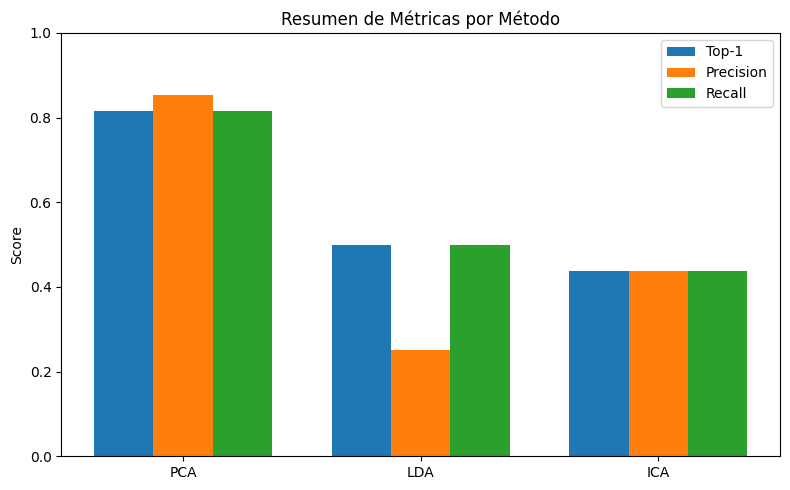

In [ ]:
# Bloque 11: Gráfica resumen de métricas por método
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Construimos una tabla con las métricas calculadas previamente
res = pd.DataFrame({
    "Metodo":   ["PCA", "LDA", "ICA"],
    "Top-1":    [top1_pca, top1_lda, top1_ica],
    "Top-5":    [top5_pca, top5_lda, top5_ica],
    "Precision":[prec_pca, prec_lda, prec_ica],
    "Recall":   [rec_pca, rec_lda, rec_ica],
}).set_index("Metodo")

display(res.style.format("{:.4f}"))

# Gráfico agrupado: Top-1 vs Precision vs Recall para cada método
metrics_to_plot = ["Top-1", "Precision", "Recall"]
X = np.arange(len(res.index))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(X - width, res[metrics_to_plot[0]].values, width, label=metrics_to_plot[0])
plt.bar(X,          res[metrics_to_plot[1]].values, width, label=metrics_to_plot[1])
plt.bar(X + width,  res[metrics_to_plot[2]].values, width, label=metrics_to_plot[2])

plt.xticks(X, res.index)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Resumen de Métricas por Método")
plt.legend()
plt.tight_layout()
plt.show()

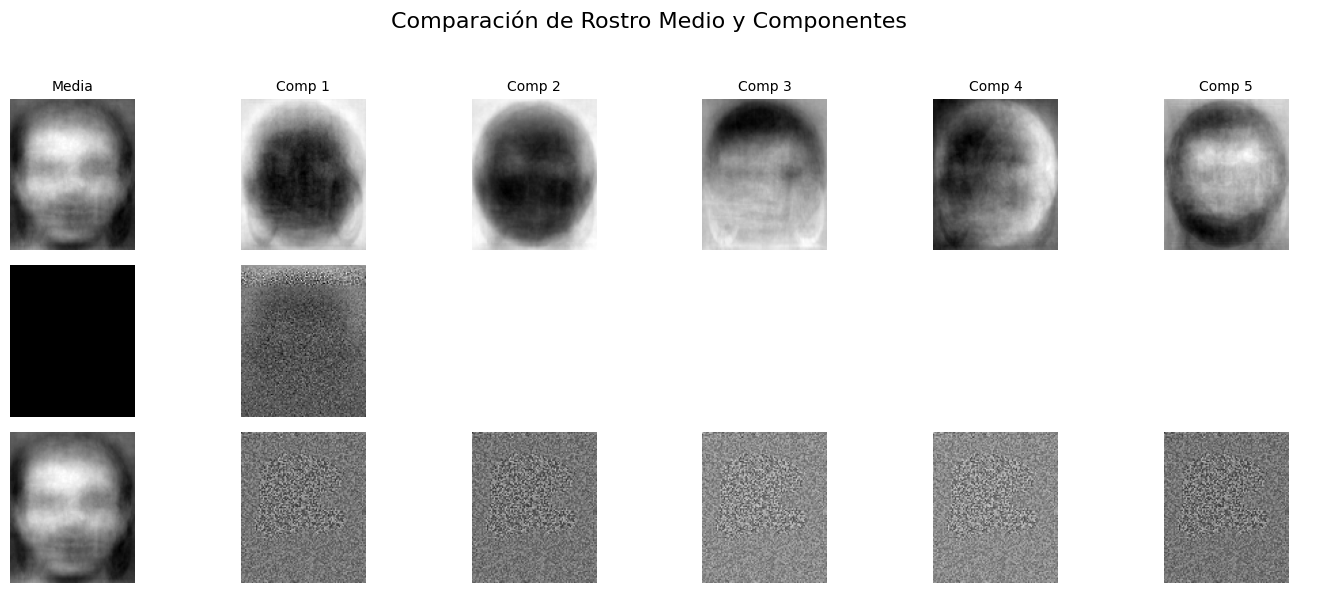

In [ ]:
# Bloque 15: Visualización comparativa PCA, LDA, ICA con labels

import matplotlib.pyplot as plt

h, w = 112, 92  # dimensiones de tus imágenes

def prepare_faces(P, mean=None, n_comp=5, include_mean=True):
    """Devuelve lista de imágenes: [media, comp1, comp2, ...]"""
    images = []
    if include_mean and mean is not None:
        images.append(mean.reshape(h, w))
    else:
        images.append(np.zeros((h, w)))  # placeholder vacío
    for i in range(min(n_comp, P.shape[1])):
        images.append(P[:, i].reshape(h, w))
    return images

# Preparamos cada conjunto
faces_pca = prepare_faces(space_pca, mean_pca, n_comp=5, include_mean=True)
faces_lda = prepare_faces(W_lda, mean=None, n_comp=1, include_mean=False)  # Fisherface binaria
faces_ica = prepare_faces(P_ica, mean_ica, n_comp=5, include_mean=True)

methods = ["PCA (Eigenfaces)", "LDA (Fisherface)", "ICA (Independent Faces)"]
all_faces = [faces_pca, faces_lda, faces_ica]

# --- Plot ---
cols = 6  # 1 media + 5 componentes
fig, axes = plt.subplots(len(all_faces), cols, figsize=(14, 6))
fig.suptitle("Comparación de Rostro Medio y Componentes", fontsize=16)

for i, (method, faces) in enumerate(zip(methods, all_faces)):
    for j in range(cols):
        ax = axes[i, j]
        if j < len(faces):
            ax.imshow(faces[j], cmap="gray")
        ax.axis("off")
        # Primera fila → títulos de columnas
        if i == 0:
            if j == 0:
                ax.set_title("Media", fontsize=10)
            else:
                ax.set_title(f"Comp {j}", fontsize=10)
    # Etiqueta de fila (nombre del método) en el margen izquierdo
    axes[i, 0].set_ylabel(method, fontsize=12, rotation=90, labelpad=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Bloque 16: Tabla resumen Train/Test para PCA, LDA e ICA
import numpy as np
import pandas as pd

def class_counts(y):
    y = np.asarray(y).ravel()
    labels, counts = np.unique(y, return_counts=True)
    # Devuelve dict ordenado por etiqueta
    return {int(lbl): int(cnt) for lbl, cnt in zip(labels, counts)}

def compute_metrics(scores, y_true, classes):
    top1 = topk_accuracy(scores, y_true, classes, k=1)
    top5 = topk_accuracy(scores, y_true, classes, k=5)
    y_pred = classes[np.argmax(scores, axis=1)]
    prec, rec, _, _ = precision_recall_macro(y_true, y_pred)
    return top1, top5, prec, rec

def summarize_method(name, Xtr, Xte, centroids, classes, ytr, yte):
    # Train metrics (resubstitution)
    scores_tr = predict_scores(Xtr, centroids, classes)
    m_tr = compute_metrics(scores_tr, ytr, classes)

    # Test metrics
    scores_te = predict_scores(Xte, centroids, classes)
    m_te = compute_metrics(scores_te, yte, classes)

    # Counts
    c_tr = class_counts(ytr)
    c_te = class_counts(yte)
    n_tr = int(len(ytr))
    n_te = int(len(yte))

    # Asegura columnas para etiquetas 0 y 1 si es binario; si multiclase, suma totales
    # Creamos columnas dinámicas por etiqueta encontrada
    row_tr = {
        "Metodo": name,
        "Split": "Train",
        "Muestras": n_tr,
        **{f"Clase {k}": v for k, v in c_tr.items()},
        "Top-1": m_tr[0],
        "Top-5": m_tr[1],
        "Precision": m_tr[2],
        "Recall": m_tr[3],
    }
    row_te = {
        "Metodo": name,
        "Split": "Test",
        "Muestras": n_te,
        **{f"Clase {k}": v for k, v in c_te.items()},
        "Top-1": m_te[0],
        "Top-5": m_te[1],
        "Precision": m_te[2],
        "Recall": m_te[3],
    }
    return row_tr, row_te

rows = []

# --- PCA ---
r_tr, r_te = summarize_method(
    "PCA", Xtr_pca, Xte_pca, cent_pca, classes_pca, train_labels, test_labels
)
rows += [r_tr, r_te]

# --- LDA ---
r_tr, r_te = summarize_method(
    "LDA", Xtr_lda, Xte_lda, cent_lda, classes_lda, train_labels, test_labels
)
rows += [r_tr, r_te]

# --- ICA ---
r_tr, r_te = summarize_method(
    "ICA", Xtr_ica, Xte_ica, cent_ica, classes_ica, train_labels, test_labels
)
rows += [r_tr, r_te]

# Unimos en DataFrame
summary_df = pd.DataFrame(rows)

# Orden de columnas amigable:
static_cols = ["Metodo", "Split", "Muestras"]
# Detecta dinámicamente columnas de clases (por si es multiclase)
class_cols = sorted([c for c in summary_df.columns if c.startswith("Clase ")],
                    key=lambda x: int(x.split()[-1]))
metric_cols = ["Top-1", "Top-5", "Precision", "Recall"]
summary_df = summary_df[static_cols + class_cols + metric_cols]

# Formato y despliegue
display(summary_df.style.format({
    "Top-1": "{:.4f}", "Top-5": "{:.4f}", "Precision": "{:.4f}", "Recall": "{:.4f}"
}))

# (Opcional) Guardar a CSV
summary_df.to_csv("resumen_train_test_metodos.csv", index=False)
print("Guardado: resumen_train_test_metodos.csv")

,Metodo,Split,Muestras,Clase 0,Clase 1,Top-1,Top-5,Precision,Recall
0,PCA,Train,400,200,200,0.8250,1.0000,0.8621,0.8250
1,PCA,Test,400,200,200,0.8150,1.0000,0.8535,0.8150
2,LDA,Train,400,200,200,0.5000,1.0000,0.2500,0.5000
3,LDA,Test,400,200,200,0.5000,1.0000,0.2500,0.5000
4,ICA,Train,400,200,200,0.6400,1.0000,0.6400,0.6400
5,ICA,Test,400,200,200,0.4375,1.0000,0.4374,0.4375


Guardado: resumen_train_test_metodos.csv


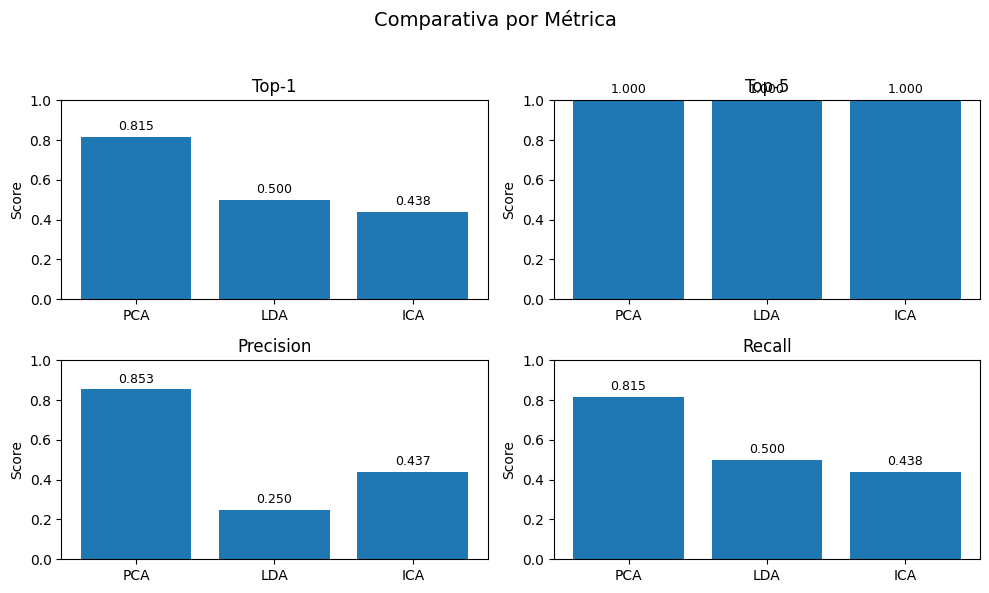

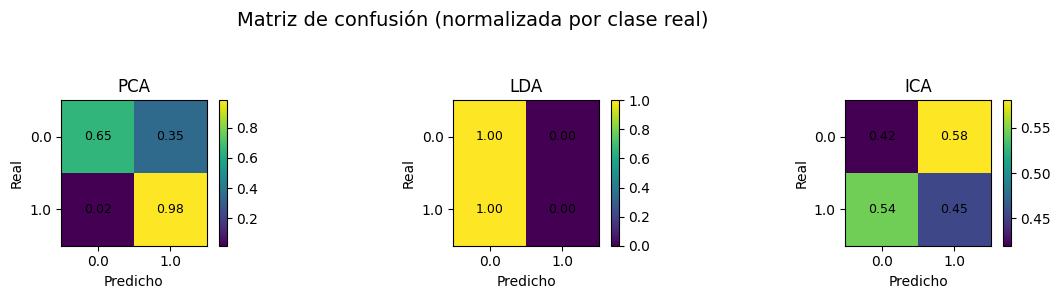

Curva de 'Accuracy vs Umbral' omitida (faltan pares o variables). Detalle: name 'pairs1_idx' is not defined


In [ ]:
# Ejemplos de gráficos por métrica (usa resultados ya calculados en bloques previos)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Tabla de resultados que ya tienes en variables ---
res = pd.DataFrame({
    "Metodo":   ["PCA", "LDA", "ICA"],
    "Top-1":    [top1_pca, top1_lda, top1_ica],
    "Top-5":    [top5_pca, top5_lda, top5_ica],
    "Precision":[prec_pca, prec_lda, prec_ica],
    "Recall":   [rec_pca, rec_lda, rec_ica],
}).set_index("Metodo")

# ---------- 1) Barras: Top-1, Top-5, Precision, Recall ----------
metrics = ["Top-1", "Top-5", "Precision", "Recall"]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()
for ax, m in zip(axes, metrics):
    vals = res[m].values
    ax.bar(res.index, vals)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Score")
    ax.set_title(m)
    # Anotar valores
    for x, v in enumerate(vals):
        ax.text(x, v + 0.02, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.suptitle("Comparativa por Métrica", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ---------- 2) Matriz de confusión (ejemplo por método, normalizada por fila) ----------
def plot_confusions(confusions, labels_list, titles):
    n = len(confusions)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3))
    if n == 1:
        axes = [axes]
    for ax, cm, labs, title in zip(axes, confusions, labels_list, titles):
        cm = cm.astype(float)
        cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)
        im = ax.imshow(cm_norm, aspect="equal")
        ax.set_title(title)
        ax.set_xlabel("Predicho")
        ax.set_ylabel("Real")
        ax.set_xticks(range(len(labs))); ax.set_xticklabels(labs)
        ax.set_yticks(range(len(labs))); ax.set_yticklabels(labs)
        # anotar celdas
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", fontsize=9)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.suptitle("Matriz de confusión (normalizada por clase real)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

plot_confusions(
    confusions=[cm_pca, cm_lda, cm_ica],
    labels_list=[lab_pca, lab_lda, lab_ica],
    titles=["PCA", "LDA", "ICA"]
)

# ---------- 3) (Opcional) Accuracy vs Umbral para verificación ----------
# Requiere pares: pairs1_idx, pairs2_idx, y_same (1=same, 0=different)
try:
    grid = np.linspace(-1, 1, 201)  # para coseno
    def acc_curve(emb, idx1, idx2, y_same):
        from numpy.linalg import norm
        a = emb[idx1]; b = emb[idx2]
        a = a / (norm(a, axis=1, keepdims=True) + 1e-12)
        b = b / (norm(b, axis=1, keepdims=True) + 1e-12)
        sims = np.sum(a*b, axis=1)
        y = np.asarray(y_same).ravel().astype(int)
        accs = []
        for t in grid:
            y_pred = (sims >= t).astype(int)
            accs.append((y_pred == y).mean())
        return np.array(accs)

    acc_pca = acc_curve(Xte_pca, pairs1_idx, pairs2_idx, y_same)
    acc_lda = acc_curve(Xte_lda, pairs1_idx, pairs2_idx, y_same)
    acc_ica = acc_curve(Xte_ica, pairs1_idx, pairs2_idx, y_same)

    plt.figure(figsize=(7,4))
    plt.plot(grid, acc_pca, label="PCA")
    plt.plot(grid, acc_lda, label="LDA")
    plt.plot(grid, acc_ica, label="ICA")
    plt.xlabel("Umbral (similitud coseno)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Umbral (verificación de identidad)")
    plt.legend()
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Curva de 'Accuracy vs Umbral' omitida (faltan pares o variables). Detalle:", e)